In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from fna.tools.signals import make_simple_kernel, pad_array

import os
import sys
import re
import sys

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [2]:
sys.path.append("../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files

In [3]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'iA1']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

In [4]:
pth = "../demyelination/data/destexhe-scaleup-sp/activity/"
fl = 'spk_destexhe-scaleup-sp_T=33_'

In [5]:
connectivity = gatherConnectivity(pth, fl, 8)

** mnist.loader ** package is not installed. To have functions using mnist.loader please install the package.
** tables ** package is not installed. To have functions using tables please install the package.


In [6]:
ex_eA1 = gatherNestConnectivity(pth, \
             fl, \
             8, "eA1", "eA1")

in_eA1 = gatherNestConnectivity(pth, \
             fl, \
             8, "iA1", "eA1")

ex_iA1 = gatherNestConnectivity(pth, \
             fl, \
             8, "eA1", "iA1")

in_iA1 = gatherNestConnectivity(pth, \
             fl, \
             8, "iA1", "iA1")

# DendriteType_Population
#perc_ex_eA1 = np.divide(ex_eA1, np.sum((ex_eA1, in_eA1), axis=0))
perc_ex_eA1 = np.divide(ex_eA1, 2000*2000)
perc_in_eA1 = np.divide(in_eA1, 500*2000)

perc_ex_iA1 = np.divide(ex_iA1, 500*2000)
perc_in_iA1 = np.divide(in_iA1, 500*500)

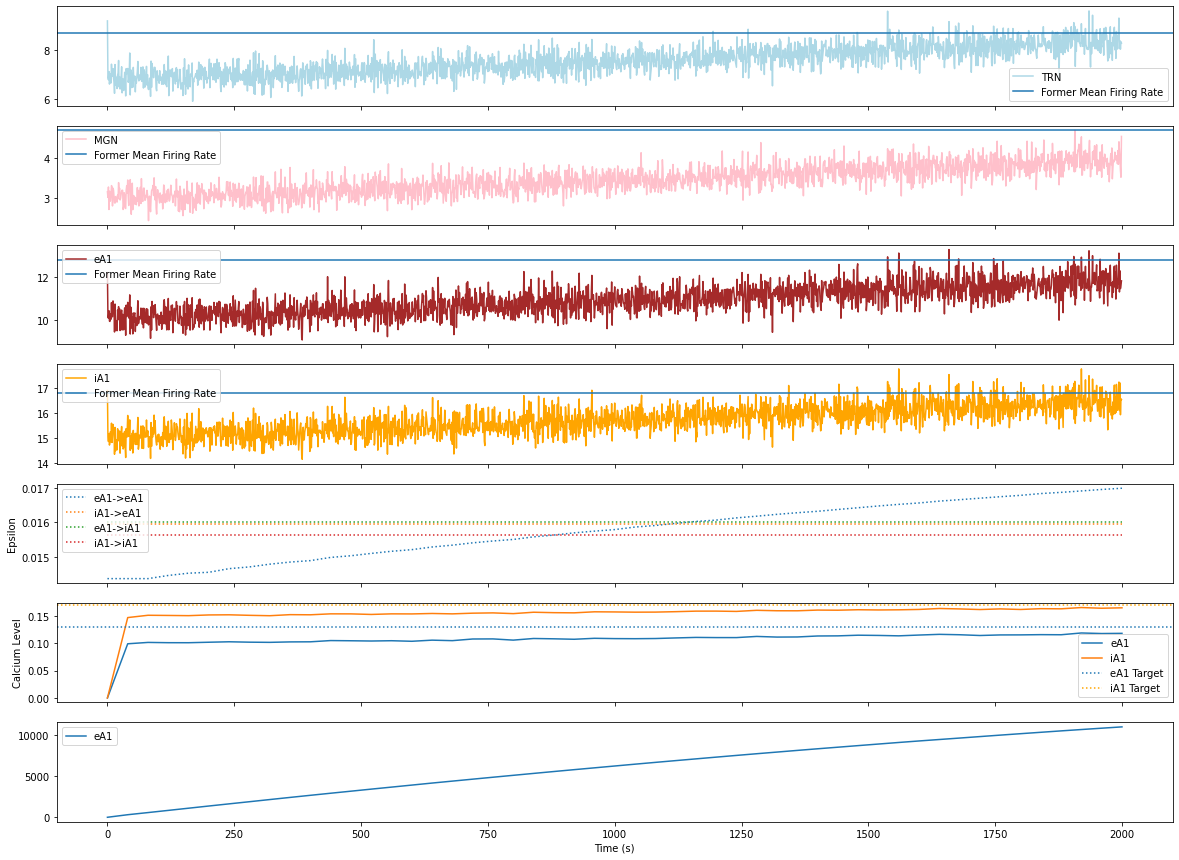

In [7]:
fig, ax = plt.subplots(nrows=7, ncols=1, sharex=True)
fig.set_size_inches(20, 15)

tstart = 0
tstop = 2000000
    
resolution = 1000

x = gatherSpikes(pth, fl, 8, "TRN", 201, 400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[0].plot(x, label='TRN', c='lightblue')
ax[0].axhline(8.7, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, 8, "MGN", 1, 200).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[1].plot(x, label='MGN', c='pink')
ax[1].axhline(4.7, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, 8, "eA1", 401, 2400).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[2].plot(x, label='eA1', c='brown')
ax[2].axhline(12.8, label="Former Mean Firing Rate")

# x, y = pipeline.smoothedspikes(p.spikeobj['iA1'].time_slice(tstart, tstop))
x = gatherSpikes(pth, fl, 8, "iA1", 2401, 2900).time_slice(tstart, tstop).firing_rate(resolution, average=True)
ax[3].plot(x, label='iA1', c='orange')
ax[3].axhline(16.8, label="Former Mean Firing Rate")

x_range = np.arange(0, 2001, 40)

ax[4].plot(x_range, perc_ex_eA1, ":", label="eA1->eA1")
ax[4].plot(x_range, perc_in_eA1, ":", label="iA1->eA1")
ax[4].plot(x_range, perc_ex_iA1, ":", label="eA1->iA1")
ax[4].plot(x_range, perc_in_iA1, ":", label="iA1->iA1")
ax[4].set_ylabel("Epsilon")

ax[5].plot(x_range, gatherCalcium(pth, fl, 8)['eA1'], label="eA1")
ax[5].plot(x_range, gatherCalcium(pth, fl, 8)['iA1'], label="iA1")
ax[5].axhline(.13, ls=":", label="eA1 Target")
ax[5].axhline(.17, ls=":", label="iA1 Target", color="orange")
ax[5].set_ylabel("Calcium Level")

ax[6].plot(x_range, connectivity['z']['Axon']['ex']['eA1'], label="eA1")

plt.xlabel("Time (s)")
# plt.ylabel("Mean Spiking Rate")

# plt.xticks(range(0, 20, 1), range(0, 1000, 50))

[ax[_].legend() for _ in range(7)];

# plt.savefig("/home/pbr-student/Downloads/thesis-plots/destexhe-sp-" + fl + ".pdf")

## How does the Calcium Level relate to Epsilon

In [8]:
ca_ea1 = gatherCalcium(pth, fl, 8)['eA1']
ca_ia1 = gatherCalcium(pth, fl, 8)['iA1']

Text(0.5, 0, 'Epsilon')

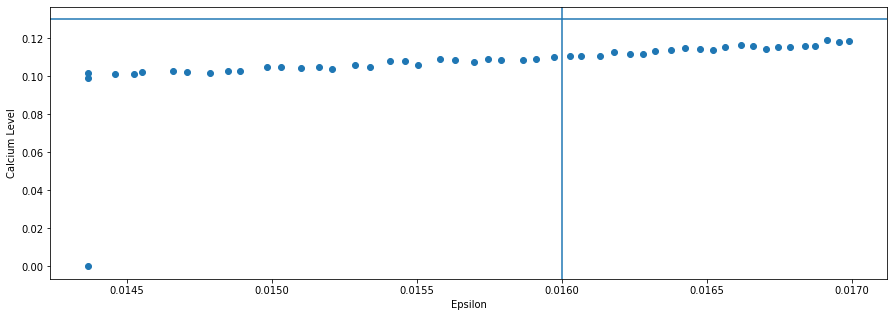

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

ax.scatter(perc_ex_eA1, ca_ea1)

ax.axhline(.13)
ax.axvline(.016, label="Target Firing Rate")

ax.set_ylabel("Calcium Level");
ax.set_xlabel("Epsilon")

## How is the relationship between the Mean Firing Rate and the Ca Level 

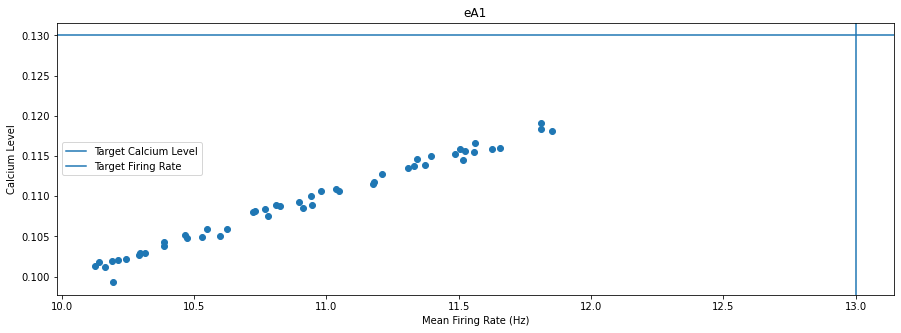

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

ea1_mfr = gatherSpikes(pth, fl, 8, "eA1", 401, 2400).firing_rate(40000, average=True)
ax.scatter(ea1_mfr, ca_ea1[1:])

ax.axhline(.13, label="Target Calcium Level")
ax.axvline(13, label="Target Firing Rate")

ax.set_ylabel("Calcium Level");
ax.set_xlabel("Mean Firing Rate (Hz)")

ax.legend()

ax.set_title("eA1");


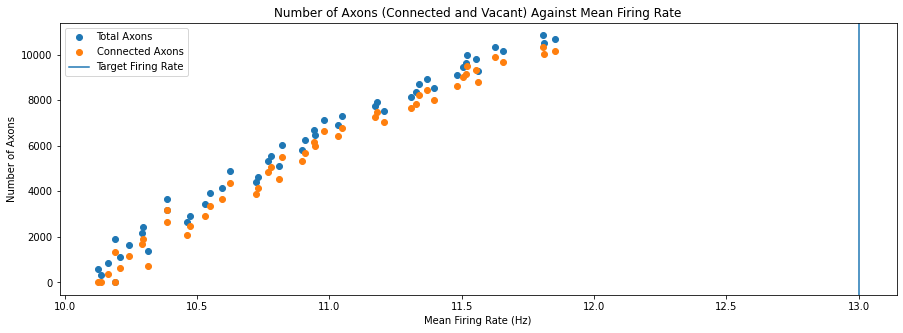

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

ea1_mfr = gatherSpikes(pth, fl, 8, "eA1", 401, 2400).firing_rate(40000, average=True)
ax.scatter(ea1_mfr, connectivity['z']['Axon']['ex']['eA1'][:-1], label="Total Axons")
ax.scatter(ea1_mfr, connectivity['z_connected']['Axon']['ex']['eA1'][:-1], label="Connected Axons")

ax.axvline(13, label="Target Firing Rate")
ax.legend();

ax.set_ylabel("Number of Axons");
ax.set_xlabel("Mean Firing Rate (Hz)")
ax.set_title("Number of Axons (Connected and Vacant) Against Mean Firing Rate");

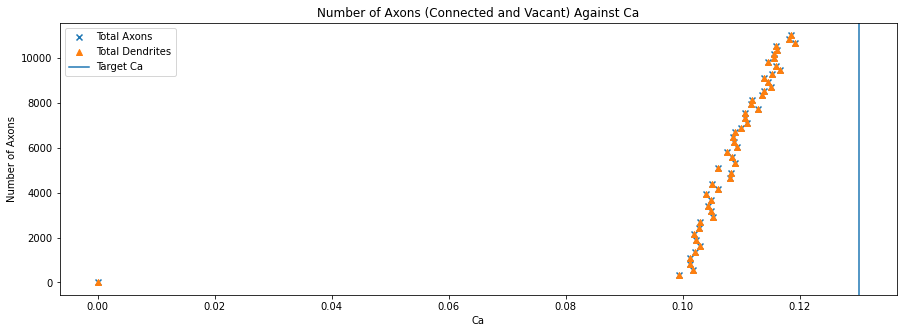

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

alpha = 1

ax.scatter(ca_ea1, connectivity['z']['Axon']['ex']['eA1'], label="Total Axons", alpha=alpha, marker='x')
ax.scatter(ca_ea1, connectivity['z']['Den']['ex']['eA1'], label="Total Dendrites", alpha=alpha, marker='^')
# ax.scatter(ca_ea1, connectivity['z_connected']['Axon']['ex']['eA1'], label="Total Connected Axons", alpha=alpha, marker='+')
# ax.scatter(ca_ea1, connectivity['z_connected']['Den']['ex']['eA1'], label="Total Connected Axons", alpha=alpha, marker="1")

ax.axvline(.13, label="Target Ca")

ax.legend()

ax.set_ylabel("Number of Axons");
ax.set_xlabel("Ca")
ax.set_title("Number of Axons (Connected and Vacant) Against Ca");

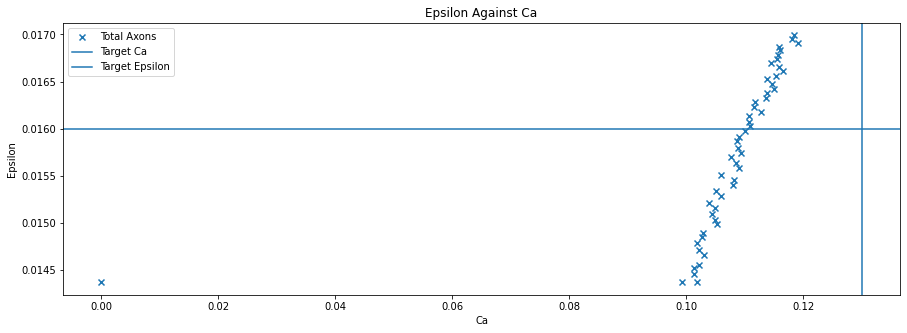

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

alpha = 1

ax.scatter(ca_ea1, perc_ex_eA1, label="Total Axons", alpha=alpha, marker='x')

ax.axvline(.13, label="Target Ca")
ax.axhline(.016, label="Target Epsilon")

ax.legend()

ax.set_ylabel("Epsilon");
ax.set_xlabel("Ca")
ax.set_title("Epsilon Against Ca");

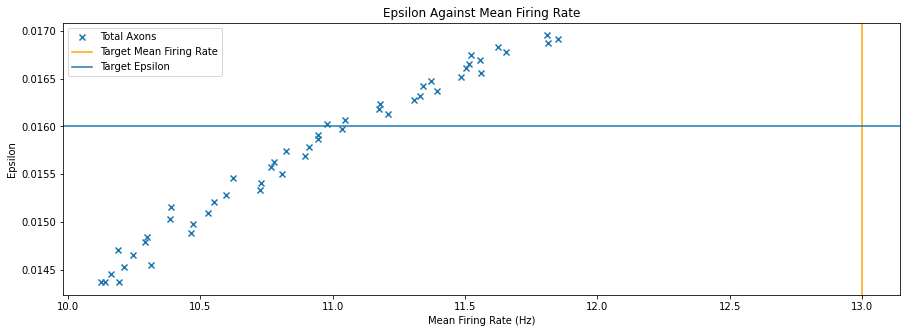

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

ax.scatter(\
           gatherSpikes(pth, fl, 8, "eA1", 401, 2400).firing_rate(40000, average=True), \
           perc_ex_eA1[:-1], label="Total Axons", marker='x')

ax.axvline(13, label="Target Mean Firing Rate", c="orange")
ax.axhline(.016, label="Target Epsilon")

ax.legend()

ax.set_xlabel("Mean Firing Rate (Hz)");
ax.set_ylabel("Epsilon")
ax.set_title("Epsilon Against Mean Firing Rate");

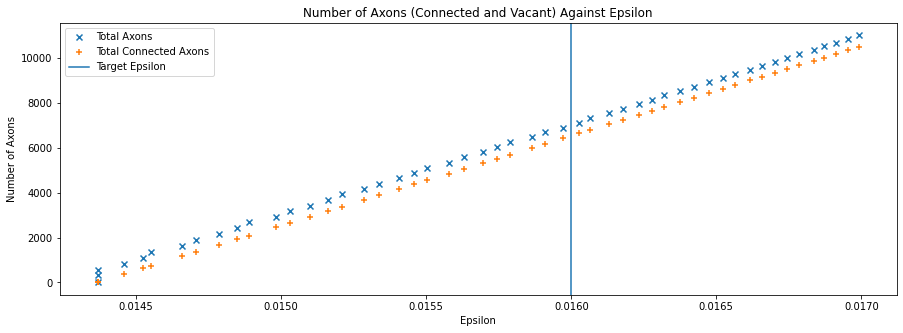

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
fig.set_size_inches(15, 5)

alpha = 1

ax.scatter(perc_ex_eA1, connectivity['z']['Axon']['ex']['eA1'], label="Total Axons", alpha=alpha, marker='x')
# ax.scatter(perc_ex_eA1, connectivity['z']['Den']['ex']['eA1'], label="Total Dendrites", alpha=alpha, marker='^')
ax.scatter(perc_ex_eA1, connectivity['z_connected']['Axon']['ex']['eA1'], label="Total Connected Axons", alpha=alpha, marker='+')
# ax.scatter(perc_ex_eA1, connectivity['z_connected']['Den']['ex']['eA1'], label="Total Connected Axons", alpha=alpha, marker="1")

ax.axvline(.016, label="Target Epsilon")

ax.legend()

ax.set_ylabel("Number of Axons");
ax.set_xlabel("Epsilon")
ax.set_title("Number of Axons (Connected and Vacant) Against Epsilon");